In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2 as cv
import random
from PIL import Image
%matplotlib notebook

print(cv.__version__)

4.4.0


In [2]:
data_path = os.path.join(os.getcwd(), "Data")

#image_names = ["IMG_2642.jpg", "IMG_2643.jpg", "IMG_2644.jpg", "IMG_2645.jpg"]
image_names = ["IMG_2654.jpg", "IMG_2655.jpg"]
image_paths = [os.path.join(data_path, image_name) for image_name in image_names]
im_array = [(cv.imread(im_path, cv.IMREAD_GRAYSCALE)) for im_path in image_paths]

rows, cols = im_array[0].shape
div_factor = cols / 400 
dims = (int(cols / div_factor), int(rows / div_factor))

scaled_im_array = []

for i in range(len(im_array)):
    scaled_im_array.append(cv.resize(im_array[i], dims, interpolation=cv.INTER_AREA))

# Part 1: Affine Factorization
### The goal of this part of the assignment is to implement the Tomasi and Kanade affine structure from motion method as described in [this lecture](https://slazebni.cs.illinois.edu/fall22/lec18_sfm.pptx). You will be working with Carlo Tomasi's 101-frame hotel sequence:


In [3]:
N_MATCHES = 300
s = 4
N_RANSAC = 1000
INLIER_THRESHOLD = 0.5

QR_HEIGHT_CM = 5.9

In [4]:
# Provided code for plotting inlier matches between two images
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# constructs matrix A from lecture, projects locations from left image 
# onto locations in right image
def construct_A(l_homo_coords, r_homo_coords):
    zero_T = np.zeros(3)
    A = np.empty((8,9))
    for i in range(s):
        x_T = l_homo_coords[i]
        row_1 = np.hstack((zero_T, x_T, -1 * r_homo_coords[i][1] * x_T))
        row_2 = np.hstack((x_T, zero_T, -1 * r_homo_coords[i][0] * x_T))
        A[2*i] = row_1
        A[2*i+1] = row_2
    return A

# convert 2D homogeneous coords to regular 2D coords
def homo_to_norm(homo_coords):
    return np.array((homo_coords[0] / homo_coords[2], homo_coords[1] / homo_coords[2]))

# warp a point using a homography matrix
def warp_point(normal_coords, homo_matrix):
    # convert coordinates to homogenous coordinates
    homo_coords = np.array(normal_coords + (1,))
    # compute Hx, projected coordinates of homo_coords
    proj_homo_coords = np.matmul(homo_matrix, homo_coords)
    # convert projected homo coordinates back to normal coordinates
    return homo_to_norm(proj_homo_coords) 

# compute inliers and avg residuals for given homography
def compute_inliers(putatives, l_kps, r_kps, homo_matrix):
    num_inliers = 0
    total_residuals = 0.
    inliers = []
    # cycle through all putatives for inliers
    for i in range(len(putatives)):
        # normal coordinates for both points
        r_coords = r_kps[matches[i].trainIdx].pt
        l_coords = l_kps[matches[i].queryIdx].pt
        # warp point with homography matrix
        proj_l_coords = warp_point(l_coords, homo_matrix)
        # compute SSD between projected left coords and known right coords
        residual = np.sum((r_coords - proj_l_coords)**2)
        # if less than threshold, count it
        if residual < INLIER_THRESHOLD:
            num_inliers += 1
            total_residuals += residual
            # append inlier as 1D array of length 4 (leftcoords, rightcoords
            inliers.append(np.hstack((l_coords, r_coords)))    
    return np.array(inliers), total_residuals / num_inliers


# RANSAC PARAMETERS
def RANSAC(putatives, l_kps, r_kps):
    # our return values
    best_num_inliers = 0
    best_avg_inlier_residual = 0
    best_homo_matrix = np.empty((3,3))
    best_inliers = []
    
    # iterate N_RANSAC times
    for i in range(N_RANSAC):
        # draw s(4) points at random 
        matches = random.sample(putatives, s)
        # matches are list of elements of form (x1, y1), (x2, y2)
        # translate to homogeneous coordinates
        coords_left = np.array([np.array(l_kps[matches[i].queryIdx].pt + (1,)) for i in range(s)])
        coords_right = np.array([np.array(r_kps[matches[i].trainIdx].pt + (1,)) for i in range(s)])
        
#         coords_left = np.hstack(matches[:,0], np.ones(len(matches)))
#         coords_right = np.hstack(matches[:,1], np.ones(len(matches)))
        
        # construct matrix A as described in lecture
        A = construct_A(coords_left, coords_right)
        # find solution for homography matrix H
        U_, s_, v_ = np.linalg.svd(A)
        min_s_val = v_[-1]
        homo_matrix = min_s_val.reshape((3,3))
        # use H to compute inliers
        inliers, avg_residual = compute_inliers(putatives, l_kps, r_kps, homo_matrix)
        num_inliers = len(inliers)
        # update best homography
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_avg_inlier_residual = avg_residual
            best_homo_matrix = homo_matrix
            best_inliers = inliers
    return best_inliers, best_avg_inlier_residual, best_homo_matrix

In [5]:
img1 = scaled_im_array[0] # queryImage
img2 = scaled_im_array[1] # trainImage

<IPython.core.display.Javascript object>


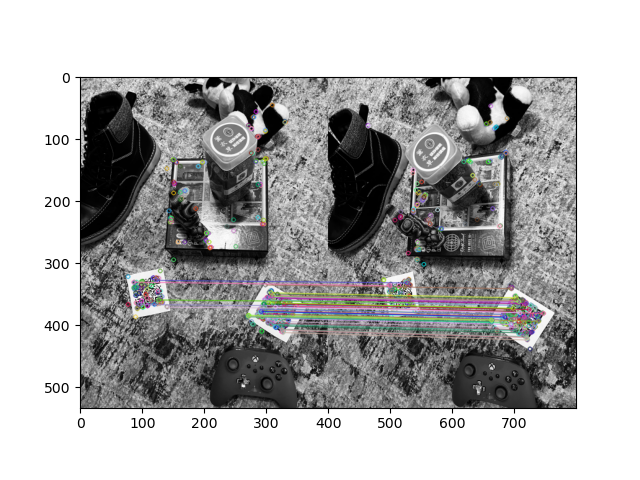

(<matplotlib.image.AxesImage at 0x22c08bca430>, None)

In [6]:
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)


# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:50],None)
plt.imshow(img3),plt.show()

In [7]:
N_MATCHES = 50
putatives = matches[:N_MATCHES]
# actual RANSAC calculation
best_inliers, best_avg_inlier_residual, best_homo_matrix = RANSAC(putatives, kp1, kp2)

In [8]:
data_matrix = best_inliers.T

print(data_matrix)

[[294.         312.         307.         312.         325.44000244
  289.44000244 296.52484131 324.         309.31204224 311.04003906
  319.68002319 326.         309.6000061  317.95202637 304.80001831
  323.         290.         343.         303.         311.
  292.         308.         289.20001221 327.         329.
  325.20001221 271.22695923 140.34127808 304.         315.        ]
 [381.         368.         373.         358.80001831 400.32000732
  375.84002686 364.9536438  355.68002319 352.51202393 352.51205444
  364.32000732 407.         351.36001587 349.05603027 368.40002441
  356.         378.         382.         396.         393.
  377.         398.         373.20001221 411.         365.
  405.6000061  383.2013855  370.26211548 363.         370.        ]
 [287.         306.         301.         306.         319.68002319
  282.24002075 290.30404663 319.68002319 304.12802124 304.81924438
  313.92001343 320.         303.84002686 312.76803589 298.80001831
  318.         283.      

In [9]:
img1 = im_array[0] # queryImage
img2 = im_array[1] # trainImage

# detect QR codes in the scene
qcd = cv.QRCodeDetector()

# for img in im_array:
#     retval1, decoded_info1, points1, straight_qrcode1 = qcd.detectAndDecodeMulti(img)
#     print(decoded_info1)

In [10]:
retval1, decoded_info1, points1, straight_qrcode1 = qcd.detectAndDecodeMulti(img1)
retval2, decoded_info2, points2, straight_qrcode2 = qcd.detectAndDecodeMulti(img2)

In [11]:
# extract robot QR code info and append to data_matrix (or replace data_matrix?)
GEORGE = 'Robot 1 (George)'
JEFF = 'Robot 2 (Jeff)'

index_george_1 = decoded_info1.index(GEORGE)
index_george_2 = decoded_info2.index(GEORGE)
index_jeff_1 = decoded_info1.index(JEFF)
index_jeff_2 = decoded_info2.index(JEFF)

george_corners_1 = points1[index_george_1].T
george_corners_2 = points2[index_george_2].T
jeff_corners_1 = points1[index_jeff_1].T
jeff_corners_2 = points2[index_jeff_2].T

george_corners = np.vstack((george_corners_1, george_corners_2))
jeff_corners = np.vstack((jeff_corners_1, jeff_corners_2))

scaled_corners = np.hstack((george_corners, jeff_corners)) / div_factor

data_matrix = np.hstack((data_matrix, scaled_corners))
print(data_matrix)

[[294.         312.         307.         312.         325.44000244
  289.44000244 296.52484131 324.         309.31204224 311.04003906
  319.68002319 326.         309.6000061  317.95202637 304.80001831
  323.         290.         343.         303.         311.
  292.         308.         289.20001221 327.         329.
  325.20001221 271.22695923 140.34127808 304.         315.
  134.86462402  91.26984406  84.65536499 127.70616913 351.57785034
  327.71704102 283.30847168 307.27514648]
 [381.         368.         373.         358.80001831 400.32000732
  375.84002686 364.9536438  355.68002319 352.51202393 352.51205444
  364.32000732 407.         351.36001587 349.05603027 368.40002441
  356.         378.         382.         396.         393.
  377.         398.         373.20001221 411.         365.
  405.6000061  383.2013855  370.26211548 363.         370.
  364.61325073 374.47091675 329.88265991 320.07174683 369.48477173
  413.04718018 384.43783569 342.85714722]
 [287.         306.       

In [12]:
means = np.mean(data_matrix, axis=1, keepdims=True)
norm_matrix = data_matrix - means

m2, n = norm_matrix.shape
m = m2 // 2

print("m: " + str(m))
print("n: " + str(n))

m: 2
n: 38


Apply SVD to the 2M x N data matrix to express it as D = U @ W @ V' (using NumPy notation) where U is a 2Mx3 matrix, W is a 3x3 matrix of the top three singular values, and V is a Nx3 matrix. You can use numpy.linalg.svd to compute this decomposition. Next, derive structure and motion matrices from the SVD as explained in the lecture.

In [13]:
U, W, V_T = np.linalg.svd(norm_matrix)
U_3 = U[:,:3]
SIGMA_3 = np.diag(W[:3])
VT_3 = V_T[:3]

M = U_3 @ np.sqrt(SIGMA_3)
S = np.sqrt(SIGMA_3) @ VT_3

Find the matrix Q to eliminate the affine ambiguity using the method described on slide 32 of the lecture.

In [14]:
coeff = np.empty((4*m,6))
vec = np.empty((4*m))
for i in range(m):
    A = M[2*i:2*i+2]
    A11 = A[0][0]
    A12 = A[0][1]
    A13 = A[0][2]
    A21 = A[1][0]
    A22 = A[1][1]
    A23 = A[1][2]
    coeff[4*i]   = np.array([A11*A11, A11*A12, A11*A13, A12*A12, A12*A13, A13*A13])
    coeff[4*i+1] = np.array([A21*A11, A21*A12, A21*A13, A22*A12, A22*A13, A23*A13])
    coeff[4*i+2] = np.array([A11*A21, A11*A22, A11*A23, A12*A22, A12*A23, A13*A23])
    coeff[4*i+3] = np.array([A21*A21, A21*A22, A21*A23, A22*A22, A22*A23, A23*A23])
    vec[4*i]   = 1
    vec[4*i+1] = 0
    vec[4*i+2] = 0
    vec[4*i+3] = 1  
    
x, residuals, rank, s = np.linalg.lstsq(coeff, vec)
L = np.array([[x[0], x[1], x[2]], [x[1], x[3], x[4]], [x[2], x[4], x[5]]])
print("L:")
print(L)
Q = np.linalg.cholesky(L)
print("Q:")
print(Q)

MQ = M@Q
QS = np.linalg.inv(Q)@S

D = MQ@QS
D_trans = D + means

L:
[[ 3.33005237e-03  1.39659171e-05  1.49380970e-03]
 [ 1.39659171e-05  1.18078205e-02 -7.65650415e-04]
 [ 1.49380970e-03 -7.65650415e-04  6.07291865e-03]]
Q:
[[ 0.05770661  0.          0.        ]
 [ 0.00024202  0.10866353  0.        ]
 [ 0.02588629 -0.00710372  0.0731598 ]]


C:\Users\dista\AppData\Local\Temp\ipykernel_6168\2478342301.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, residuals, rank, s = np.linalg.lstsq(coeff, vec)


Use matplotlib to display the 3D structure (in your report, you may want to include snapshots from several viewpoints to show the structure clearly). Discuss whether or not the reconstruction has an ambiguity.

In [15]:
# calculate distances

# create sequences of corners for each shape (repeating the first corner again at the end)
square_1 = np.c_[QS[:,-8:-4], QS[:,-8]]
square_2 = np.c_[QS[:,-4:], QS[:,-4]]

square_1_perimeter = 0
square_2_perimeter = 0

# loop through all pairs of corners to calculate total square perimeters
for i in range(4):
    square_1_perimeter += np.linalg.norm(square_1[:,i]-square_1[:,i+1])
    square_2_perimeter += np.linalg.norm(square_2[:,i]-square_2[:,i+1])

average_side_length = (square_1_perimeter + square_2_perimeter) / 8

# calculate ratio of 3d distances to real world distance
# now, we can use this to measure distances, take any distance in 3d and divide by this ratio to get CM
ratio_3d_real = average_side_length / QR_HEIGHT_CM

print(ratio_3d_real)

# now we calculate the center of both squares in 3d
center_1 = np.mean(QS[:,-8:-4], axis=1)
center_2 = np.mean(QS[:,-4:], axis=1)

center_line = (center_1 + center_2) / 2

print(center_1)
print(center_2)

distance_3d = np.linalg.norm(center_1-center_2)

distance_real = distance_3d / ratio_3d_real

print("Distance between squares in cm: " + str(distance_real))

# GROUND TRUTH: 27.5
true_distance_cm = 27.5

8.51825456026927
[-174.3612399    -1.26550342   65.63301838]
[32.72111821  0.8959606  -8.31351763]
Distance between squares in cm: 25.815109080820857


<IPython.core.display.Javascript object>


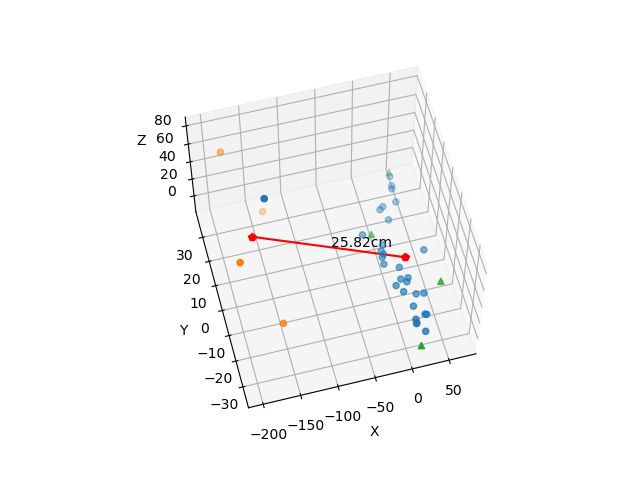

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(QS[0][:-8], QS[1][:-8], QS[2][:-8])
ax.scatter(QS[0][-8:-4], QS[1][-8:-4], QS[2][-8:-4], marker='o')
ax.scatter(QS[0][-4:], QS[1][-4:], QS[2][-4:], marker='^')

ax.plot([center_1[0], center_2[0]], [center_1[1], center_2[1]], [center_1[2], center_2[2]], marker = 'p', color='red')
ax.text(center_line[0], center_line[1], center_line[2], "{:.2f}".format(distance_real) + "cm")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Display three frames with both the observed feature points and the estimated projected 3D points overlayed. 

<IPython.core.display.Javascript object>


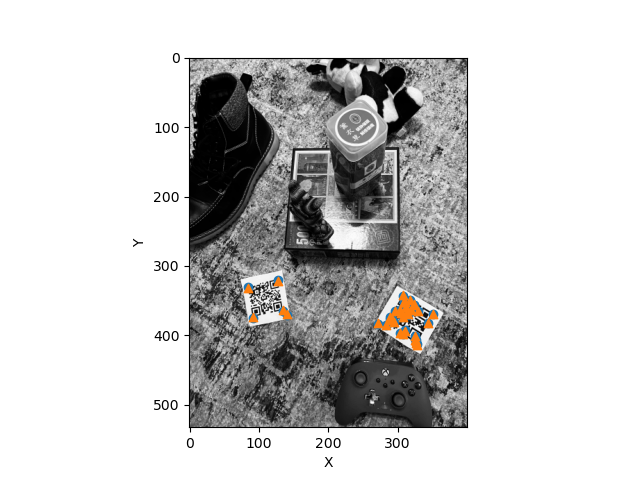

<IPython.core.display.Javascript object>


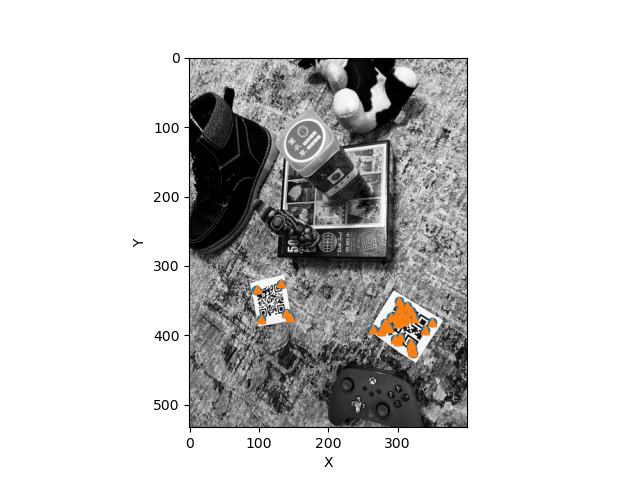

In [17]:
ct = 0
for i in [0,1]:
    xs = data_matrix[2*i]
    ys = data_matrix[2*i+1]
    
    x_projs = D_trans[2*i]
    y_projs = D_trans[2*i+1]
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(xs, ys, marker='o')
    ax.scatter(x_projs, y_projs, marker='^')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    plt.imshow(scaled_im_array[ct],cmap='gray')
    ct+=1

Report your total residual (sum of squared Euclidean distances, in pixels, between the observed and the reprojected features) over all the frames, and plot the per-frame residual as a function of the frame number.

In [18]:
# residuals = np.empty((m))
# for i in range(m):
#     coords = data_matrix[2*i:2*i+2]
#     proj_coords = D_trans[2*i:2*i+2]
    
#     residuals[i] = np.sum(np.linalg.norm(coords-proj_coords)**2, axis=0)
    
# total_residual = np.sum(residuals)

# xs = np.array([i for i in range(1, m+1)])

# fig = plt.figure()
# ax = fig.add_subplot()
# ax.set_xlabel('Frame')
# ax.set_ylabel('Residual')
# ax.plot(xs, residuals)

# print(total_residual)

# plt.show()

In [19]:
# camera_id = 0
# delay = 1
# window_name = 'OpenCV QR Code'

# qcd = cv.QRCodeDetector()
# cap = cv.VideoCapture(camera_id)

# while True:
#     ret, frame = cap.read()

#     if ret:
#         ret_qr, decoded_info, points, _ = qcd.detectAndDecodeMulti(frame)
#         if ret_qr:
#             for s, p in zip(decoded_info, points):
#                 if s:
#                     print(s)
#                     color = (0, 255, 0)
#                 else:
#                     color = (0, 0, 255)
#                 frame = cv.polylines(frame, [p.astype(int)], True, color, 8)
#         cv.imshow(window_name, frame)

#     if cv.waitKey(delay) & 0xFF == ord('q'):
#         break

# cv.destroyWindow(window_name)